In Part 2 of the project, we applied our findings to an LSTM model. The input data consisted of the CTSH time series and its rolling correlation, and the model was used to predict the exogenous variable, SIRI.

# Loading DataFrame

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [50]:

import pickle
with open('data/pickle_files/final_dataframe.pkl', 'rb') as file:
    df = pickle.load(file)

# Drop one of the 'correlation' columns from final_df
df = df.loc[:, ~df.columns.duplicated()]

# Preprocessing for RNN -> LSTM -> Evaluation 

Taken directly from the `helpermodules` module named `LSTM.py`.


In [ ]:

def prepare_lstm_data(df, input_sequence_length=60, batch_size=32, split_fraction=0.7):
    """
    Prepare data for an LSTM model using stock_1 and correlation as features,
    and stock_2 as the target.

    Args:
        df (DataFrame): Input DataFrame with columns ['AdjClose_Stock_1', 'AdjClose_Stock_2', 'Rolling_Correlation_Coefficient'].
        input_sequence_length (int): Number of past time steps to use as input.
        batch_size (int): Batch size for the TimeseriesGenerator.
        split_fraction (float): Fraction of data to use for training.

    Returns:
        train_dataset (TimeseriesGenerator): Training data generator.
        test_dataset (TimeseriesGenerator): Testing data generator.
        scaler_features (StandardScaler): Scaler used for normalizing the input features.
        scaler_target (StandardScaler): Scaler used for normalizing the target values.
    """
    # Ensure required columns are present in the DataFrame
    required_columns = ['CTSH', 'SIRI', 'correlation']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Extract the columns
    stock_1 = df['CTSH'].values.reshape(-1, 1)
    stock_2 = df['SIRI'].values.reshape(-1, 1)  # Target variable
    correlation = df['correlation'].values.reshape(-1, 1)

    # Normalize the features (stock_1 and correlation) and the target (stock_2)
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()

    # Stack features (stock_1 and correlation) together and normalize
    features = np.hstack([stock_1, correlation])
    normalized_features = scaler_features.fit_transform(features)

    # Normalize the target (stock_2)
    normalized_target = scaler_target.fit_transform(stock_2)

    # Split the data into training and test sets
    num_samples = len(df)
    train_size = int(split_fraction * num_samples)

    # Create TimeseriesGenerator instances for train and test sets
    train_dataset = TimeseriesGenerator(
        data=normalized_features[:train_size],
        targets=normalized_target[:train_size],
        length=input_sequence_length,
        batch_size=batch_size,
    )

    test_dataset = TimeseriesGenerator(
        data=normalized_features[train_size:],
        targets=normalized_target[train_size:],
        length=input_sequence_length,
        batch_size=batch_size,
    )

    return train_dataset, test_dataset, scaler_features, scaler_target


In [53]:

def lstm_model(train_dataset, scaler):
    """
    Builds, trains, and prepares an LSTM model using the training data.

    Parameters:
        train_dataset: TimeseriesGenerator providing the input and target data.
        scaler: StandardScaler used for normalizing the target data.

    Returns:
        model (Sequential): Trained LSTM model.
        inverse_transform_predictions (function): Function to inverse transform predictions.
    """
    # Infer input shape from the TimeseriesGenerator
    input_shape = train_dataset[0][0].shape[1:]  # (sequence_length, number_of_features)

    # Build the LSTM model
    model = Sequential()
    # 1st Layer
    model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))  # Increased dropout to avoid overfitting
    # 2nd Layer
    model.add(LSTM(units=64, activation='relu', return_sequences=False))
    model.add(Dropout(0.3))

    # Output Layer
    model.add(Dense(units=1))  # Single output value

    # Compile the model with a lower learning rate
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='loss',  # Monitor training loss
        patience=3,  # Stop training after 3 epochs with no improvement
        restore_best_weights=True  # Restore the best weights after stopping
    )

    # Train the model using the TimeseriesGenerator
    model.fit(train_dataset, epochs=20, callbacks=[early_stopping], verbose=1)

    # Define a helper function for inverse transformation
    def inverse_transform_predictions(predictions):
        return scaler.inverse_transform(predictions.reshape(-1, 1))

    return model, inverse_transform_predictions


In [54]:


def evaluate_and_plot(model, test_dataset, inverse_transform, scaler_target):
    """
    Make predictions, compute metrics, and plot the predicted vs. actual values.
    
    Parameters:
        model: Trained LSTM model.
        test_dataset: TimeseriesGenerator providing the test data.
        inverse_transform: Function to inverse-transform predictions.
        scaler_target: StandardScaler used for normalizing the target data.
        
    Returns:
        None
    """
    # Get the true target values and model predictions
    actuals = []
    predictions = []
    
    for i in range(len(test_dataset)):
        x_batch, y_batch = test_dataset[i]
        pred_batch = model.predict(x_batch, verbose=0)
        predictions.append(pred_batch)
        actuals.append(y_batch)
    
    # Concatenate all batches
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)

    # Inverse transform to get values back to the original scale
    predictions_original = inverse_transform(predictions)
    actuals_original = scaler_target.inverse_transform(actuals)

    # Compute metrics
    mse = mean_squared_error(actuals_original, predictions_original)
    mae = mean_absolute_error(actuals_original, predictions_original)
    r2 = r2_score(actuals_original, predictions_original)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-Squared (R²): {r2:.4f}")

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(actuals_original, label="Actual Stock 2 Prices", color='blue')
    plt.plot(predictions_original, label="Predicted Stock 2 Prices", color='orange', linestyle='dashed')
    plt.title("Actual vs Predicted Stock 2 Prices")
    plt.xlabel("Time Steps")
    plt.ylabel("Stock 2 Price")
    plt.legend()
    plt.show()


## Applying the model to the dataset and plotting results 

In [60]:
# Check for missing and infinite values before cleaning
print("Missing values per column (before):")
print(df.isna().sum())

print("\nInfinite values per column (before):")
print(np.isinf(df).sum())

# Replace NaN and infinite values with zero
df.replace([np.nan, np.inf, -np.inf], 0, inplace=True)

# Verify that all missing and infinite values have been handled
print("\nMissing values per column (after):")
print(df.isna().sum())

print("\nInfinite values per column (after):")
print(np.isinf(df).sum())


Missing values per column (before):
CTSH           0
correlation    0
SIRI           0
dtype: int64

Infinite values per column (before):
CTSH           0
correlation    0
SIRI           0
dtype: int64

Missing values per column (after):
CTSH           0
correlation    0
SIRI           0
dtype: int64

Infinite values per column (after):
CTSH           0
correlation    0
SIRI           0
dtype: int64


In [57]:
# Step 1: Prepare Data
train_dataset, test_dataset, scaler_features, scaler_target = prepare_lstm_data(
    df, input_sequence_length=60, batch_size=32, split_fraction=0.7
)



In [58]:
# Step 2: Build and Train Model
model, inverse_transform = lstm_model(train_dataset, scaler_target)


c:\Users\giuli\Repositories\nasdaq_causal-analysis_lstm\venv_12\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


c:\Users\giuli\Repositories\nasdaq_causal-analysis_lstm\venv_12\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


380/380 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.5676
Epoch 2/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0970
Epoch 3/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0854
Epoch 4/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0823
Epoch 5/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0710
Epoch 6/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0781
Epoch 7/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0728
Epoch 8/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0743
Epoch 9/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0656
Epoch 10/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.0677
Epoch 11/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0627
Epoch 12/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0578
Epoch 13/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0634
Epoch 14/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0638
Epoch 15/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 

Mean Squared Error (MSE): 0.0089
Mean Absolute Error (MAE): 0.0544
R-Squared (R²): 0.9518


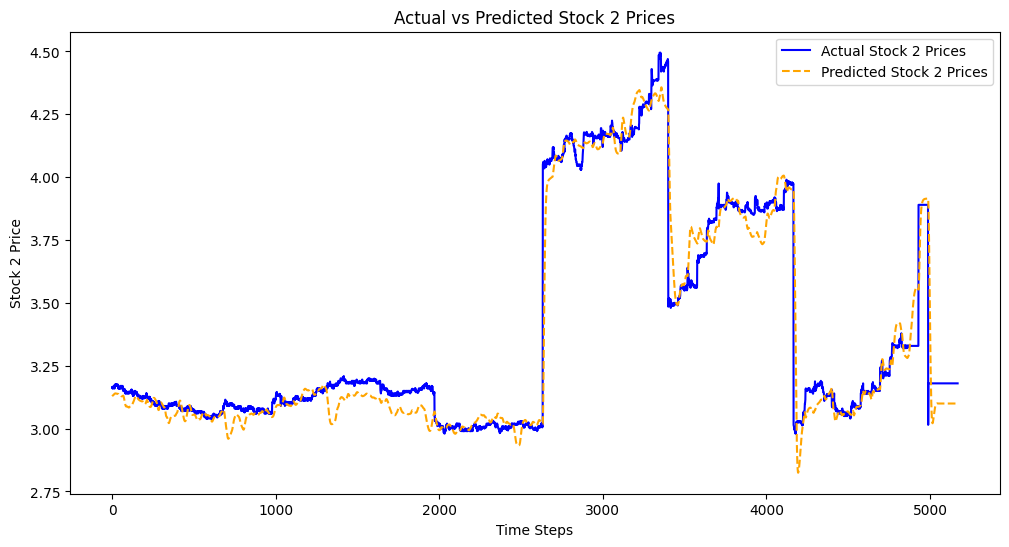

In [59]:
# Step 3: Evaluate and Plot
evaluate_and_plot(model, test_dataset, inverse_transform, scaler_target)